# Import Settings

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import os
import re
import datetime as dt
from matplotlib import pyplot  as plt
import seaborn as sns
sns.set_style("darkgrid",{'font.sans-serif':['simhei','Arial'],'grid.linestyle': '--'})

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from visualization import *
from aggregation import *
from data_handling import *

# Import data from  folder

In [4]:
# Aggregated data before August
past = pd.read_excel('summary.xlsx')

In [5]:
# import data from folder named '账单汇总', which is all the transaction data after 08-01
dir = "账单汇总"

filename_excel = []
frames = []
for root, dirs, files in os.walk(dir):
    for file in files:
        filename_excel.append(os.path.join(root, file))
        df = pd.read_csv(os.path.join(root, file), skiprows=[
                         0, 1, 2, 3], header=0, infer_datetime_format=True, date_parser = True,skipfooter=4, encoding="gbk")
        frames.append(df)
data = pd.concat(frames)

In [6]:
data = pd.concat([past,data])

# Data cleaning and transforming

In [7]:
#getting only useful fields from data
data_sim = data[['发生时间', '收入金额（+元）',
          '交易渠道', '业务类型', '备注']]
data_sim['发生时间']=pd.to_datetime(data_sim['发生时间'])
data_sim.reset_index(inplace = True, drop = True)

In [8]:
#dealing with the Chinese characters in dataset
data_sim['备注'] = [i.encode('utf-8') for i in data_sim.备注]
data_sim['备注'] = [get_chinese(i)[0]  for i in data_sim.备注]

In [9]:
types = ['公交赏金', '地铁赏金', '支付宝推荐奖励','商家权益红包']

## slicing data into different operation type

In [10]:
data_bus = data_sim[data_sim['备注']==types[0]]
data_metro = data_sim[data_sim['备注']==types[1]]
data_recommend =  data_sim[data_sim['备注']==types[2]]
data_quanyi = data_sim[data_sim['备注']==types[3]]

## Slicing data into old users and new users

In [11]:
data_new = data_bus[data_bus['收入金额（+元）']>1.0]
data_old = data_bus[data_bus['收入金额（+元）']<=1.0]

### Update sum/count for old/new users for everyday

In [12]:
travel = all_travel(data_new,data_old)

In [13]:
with pd.ExcelWriter('all_travel.xlsx') as writer:
    travel.to_excel(writer)

In [14]:
travel

,新用户笔数,老用户笔数,新用户收入,老用户收入
日期,,,,
2020-05-01,674,3949,1476.82,575.14
2020-05-02,895,4957,1952.34,721.72
2020-05-03,821,4402,1776.26,638.30
2020-05-04,714,4970,1558.24,697.86
2020-05-05,687,4804,1513.12,677.50
...,...,...,...,...
2020-09-02,815,4686,1920.30,650.16
2020-09-03,775,4341,1836.30,608.14
2020-09-04,872,4728,2035.82,685.64


### Generate daily plot for analysis

In [33]:
# get the hourly plot for the specific day
date = dt.date(2020,9,6)
today_data = get_chunk(data_old, date, field = 'date')
agg= get_aggregated(today_data,by = 'hour')
trend_plot(agg, names = ['收入','笔数','9月6日每小时收入/笔数(老用户)'], means=None, reverse = False)

### Generate monthly trend plot

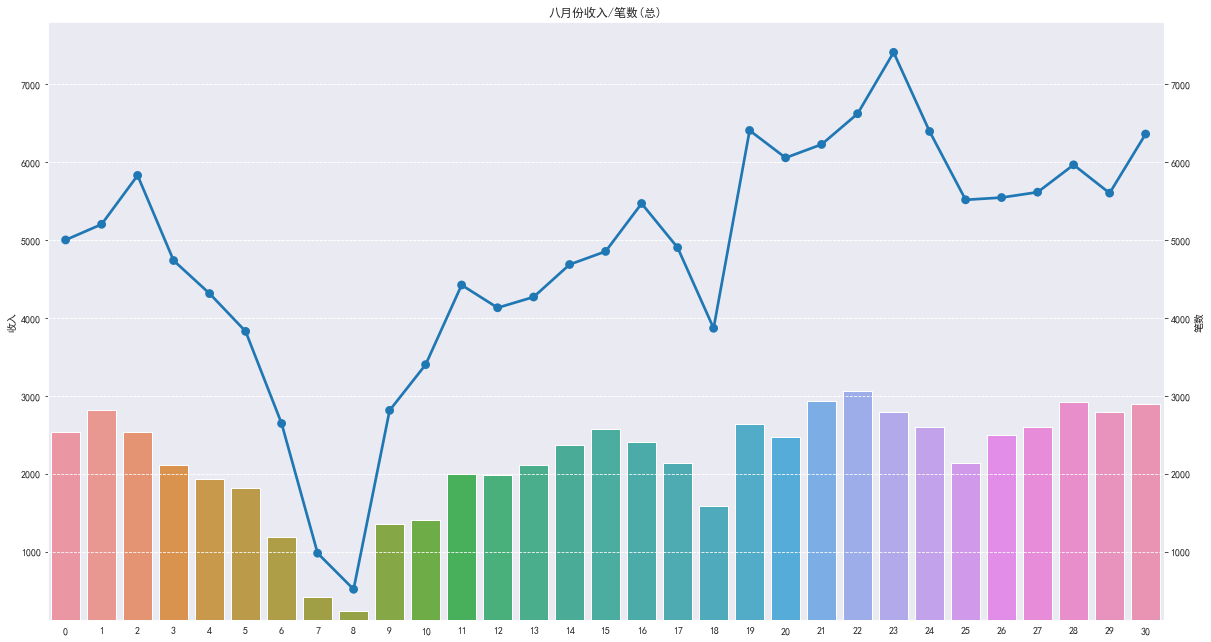

In [43]:
month = 8
monthly_data = get_chunk(data_bus, month, field = 'month')
agg= get_aggregated(monthly_data,by = 'date')
trend_plot(agg, names = ['收入','笔数','八月份收入/笔数(总)'], means=None, xtick = agg.index,reverse = False)

# Analyze anomaly

## Two days comparation

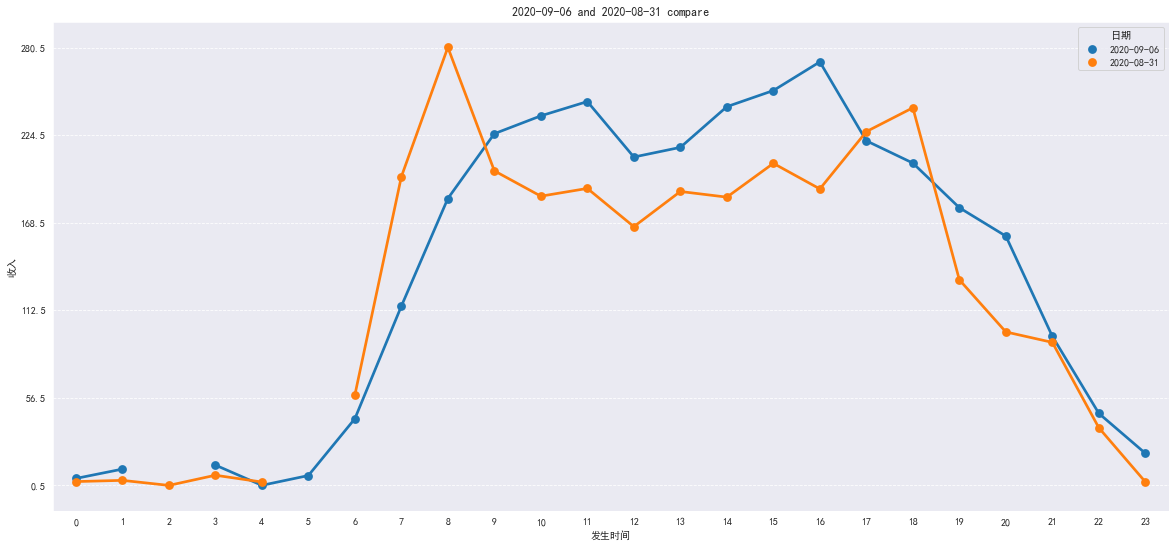

In [46]:
date1, date2 = dt.date(2020, 9, 6), dt.date(2020, 8, 31)
anomaly_data, normal_data = get_aggregated(get_chunk(data_bus, date1, field='date'), by='hour'), get_aggregated(
    get_chunk(data_bus, date2, field='date'), by='hour')
anomaly_data['日期'] = date1.strftime('%Y-%m-%d')
normal_data['日期'] = date2.strftime('%Y-%m-%d')
data_all =  pd.concat([anomaly_data,normal_data])
anomaly_plot(data_all,name = str(date1)+' and '+str(date2)+' compare',if_sum=True,xtick = np.arange(0,24,1))